# Contexte du projet


Une équipe médicale souhaite tester l’apport de l’intelligence artificielle dans **le diagnostic automatisé de la pneumonie à partir de radios thoraciques.** Elle a besoin d’un prototype fonctionnel (Proof of Concept) permettant de démontrer la faisabilité d’**un système de classification binaire d’images médicales**.

>Le problème posé consiste à réutiliser un modèle de vision par ordinateur **pré-entraîné (type CNN)** pour l’adapter au contexte médical, sans repartir d’un entraînement complet.

> Dans une logique de mise en production à moyen terme, il est également attendu de documenter et tracer les expérimentations réalisées. L’usage de **MLflow** est proposé pour initier cette démarche, en assurant le suivi des performances, la traçabilité des essais et la gestion des versions de modèles dans une perspective MLOps.

# Modalités d'évaluation
Évaluation individuelle à partir du livrable (notebook). 
Le barème porte sur 
- **la qualité de la démarche (pertinence des choix, rigueur des étapes, clarté des explications),** 
- **la bonne compréhension du transfert learning,**
- **et l’initiation à MLflow (usage basique)**.

# Livrables
Un **lien GitHub** contenant les travaux réalisés, notamment un notebook complet, structuré, lisible et commenté, incluant :
- Préparation et exploration du dataset
- Mise en place du modèle pré-entraîné et adaptation
- Entraînement, évaluation (matrice de confusion, courbes, métriques etc...)
- Suivi des expériences via MLflow
- Le dépôt du code sur GitHub avec les travaux réalisé (notebook) avec un README synthétique

# Critères de performance
- Le notebook couvre toutes **les étapes clés de la démarche** (pré-traitement, modélisation, évaluation)
- Les **choix techniques sont justifiés** avec clarté et cohérence
- Le **modèle est adapté** de manière correcte à la tâche de classification binaire
- L’**évaluation du modèle est rigoureuse** (métriques pertinentes, commentaires clairs)
- La première utilisation de **MLflow est fonctionnelle et comprise** (log simple de paramètres ou de métriques)
- Le **code est structuré, commenté, exécutable**
- *La performance du modèle n'est pas un critère de performances, seul compte la démarche, la compréhension et donc la clarté des notes dans le le notebook*

----

# 1. Chargement des bibliothèques nécessaires

 - Création manuelle d'un environnment virtuel `python -m venv .venv` et l'activer ` .\.venv\Scripts\Activate.ps1` (sous windows os)
 - Installer les bibliothèques `pip install -r requirements.txt` 
 - choisir le dossier .venv dans "Python: Select interpreter" (Command Palette)
 (venv contenant python 3.10 compatible avec tensorflow)
 - installer ipykernel pour executer

In [39]:
import os  # os pour manipuler des dossiers et fichiers
import numpy as np # np pour manipuler des vecteurs et matrices
import pandas as pd # pd pour traiter des dataframe et visualiser des figures
import seaborn as sns # pd pour visualiser des figures

import mlflow #  pour documenter et tracer les expérimentations réalisées.
import mlflow.tensorflow
# DL Lib
import tensorflow as tf 

from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16, DenseNet121, ResNet50V2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt  #  pour visualiser des figures
from tensorflow.keras.utils import plot_model
from sklearn.metrics import roc_curve,roc_auc_score,auc, confusion_matrix, classification_report # pd pour évaluer le modèle
import cv2
#from tensorflow import keras
#from keras.models import Model
#from keras.layers import Dense
np.set_printoptions(linewidth=np.inf)
np.set_printoptions(edgeitems=30) 

# 2. Préparation et exploration du dataset

[[[ 24  24  24]
  [ 20  20  20]
  [ 19  19  19]
  [ 17  17  17]
  [ 17  17  17]
  [ 28  28  28]
  [ 56  56  56]
  [ 58  58  58]
  [ 64  64  64]
  [ 65  65  65]
  [ 72  72  72]
  [ 74  74  74]
  [ 80  80  80]
  [ 86  86  86]
  [ 90  90  90]
  [ 90  90  90]
  [ 92  92  92]
  [ 91  91  91]
  [ 99  99  99]
  [ 98  98  98]
  [100 100 100]
  [ 99  99  99]
  [102 102 102]
  [102 102 102]
  [107 107 107]
  [107 107 107]
  [110 110 110]
  [115 115 115]
  [111 111 111]
  [134 134 134]
  ...
  [ 84  84  84]
  [ 88  88  88]
  [ 88  88  88]
  [ 93  93  93]
  [ 91  91  91]
  [ 93  93  93]
  [ 98  98  98]
  [ 98  98  98]
  [ 98  98  98]
  [ 99  99  99]
  [100 100 100]
  [115 115 115]
  [147 147 147]
  [168 168 168]
  [155 155 155]
  [140 140 140]
  [138 138 138]
  [133 133 133]
  [133 133 133]
  [138 138 138]
  [152 152 152]
  [166 166 166]
  [138 138 138]
  [ 96  96  96]
  [ 96  96  96]
  [ 94  94  94]
  [ 95  95  95]
  [ 95  95  95]
  [ 94  94  94]
  [ 95  95  95]]

 [[ 22  22  22]
  [ 22  22  22]


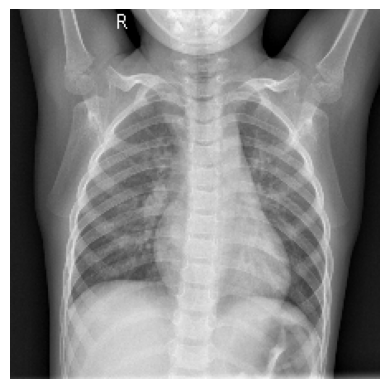

Shape (dimensions)    : (224, 224, 3)
Type des valeurs      : uint8


In [2]:
# On charge une image depuis le répertoire data/
img = cv2.imread("../data/train/NORMAL/IM-0115-0001.jpeg", cv2.IMREAD_GRAYSCALE)
# Convert to 3 channels
img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Now shape is (H, W, 3)
# Resize to model input size (e.g., 224x224)
resized_img = cv2.resize(img_rgb, (224, 224))
# Observer l'image sous forme de matrice
print(resized_img)

# Visualisation de l'image
plt.imshow(resized_img, cmap="gray")
plt.axis("off")
plt.show()

# Inspection des métadonnées de l'image
print(f"Shape (dimensions)    : {resized_img.shape}")
print(f"Type des valeurs      : {resized_img.dtype}")

## Chargement des données

In [3]:
def get_train_val(base_path: str):
    X = []  # liste pour stocker les images
    y = []  # liste pour stocker les étiquettes correspondantes

    # On parcourt les sous-dossiers du répertoire (un dossier par chiffre)
    for label in sorted(os.listdir(base_path)):
        # on ignore les fichiers qui ne sont pas des dossiers de chiffres
        if label not in ["NORMAL","PNEUMONIA"]:
            continue
        label_path = os.path.join(base_path, label)

        # On parcourt chaque image du dossier
        for file_name in os.listdir(label_path):
            file_path = os.path.join(label_path, file_name)
            # Lecture de l'image en niveaux de gris
            img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
            # Convert to 3 channels
            img_rgb = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB) # Now shape is (H, W, 3)
            # Resize to model input size (e.g., 224x224)
            resized_img = cv2.resize(img_rgb, (224, 224))
            
            if img is None:
                continue  # image illisible, on passe
            X.append(resized_img)           # on ajoute l'image à la liste
            y.append(1 if label == "PNEUMONIA" else 0)    # on ajoute le label (1 if label == "PNEUMONIA" else 0)

    # Conversion des listes en tableaux NumPy
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = get_train_val("../data/train")
X_val, y_val = get_train_val("../data/val")
X_test,y_test = get_train_val("../data/test")

## Vérification

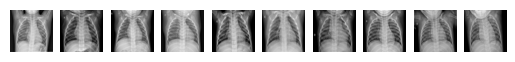

In [4]:
# Vérification des données préparées
for i in range(10):
    plt.subplot(1, 10, i + 1)
    plt.imshow(X_train[i], cmap="grey")
    plt.axis("off")

plt.show()

## Conversion et normalisation

- La conversion des entiers (0–255) en nombres à virgule (float32)
- La normalisation des pixels entre 0.0 et 1.0

In [5]:
# Les images sont au format (224, 224). On les convertit en float pour normaliser ensuite
X_train = X_train.astype("float32")
X_val = X_val.astype("float32")
X_test = X_test.astype("float32")

# Normalisation : on divise les valeurs de pixels par 255 pour les ramener entre 0 et 1
X_train /= 255.0
X_val /= 255.0
X_test /= 255.0


# 3. Modélisation

- Pour un transfer learning : choisir selon les performances le modèle de base pré-entrainé (VGG16, DenseNet121 ...) sur les données ImageNet

In [6]:
# Créer le modèle de base et exclure les couches finales du modèle de base pour ajouter nos propres couches à la fin
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_densenet = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model_resnet = ResNet50V2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

## Transfer Leanrning & Fine tuning (VGG16)

In [7]:
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Option 1: 128 neurons
x = Dropout(0.5)(x)  # réduire la probabilité d'un overfitting
predictions_vgg = Dense(1, activation='sigmoid')(x)

# Stratégie #2 : On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
base_model_vgg.trainable = False

# Architecture du modèle personnalisé
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg )


In [8]:
model_vgg

<Functional name=functional, built=True>

In [9]:
model_vgg.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,780,481 (56.38 MB)

 Trainable params: 65,793 (257.00 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

## Transfer Leanrning & Fine tuning (DenseNet121)

In [10]:
x = base_model_densenet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Option 1: 128 neurons
x = Dropout(0.5)(x)  # réduire la probabilité d'un overfitting
predictions_densenet = Dense(1, activation='sigmoid')(x)

# Stratégie #2 : On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
base_model_densenet.trainable = False

# Architecture du modèle personnalisé
model_densenet = Model(inputs=base_model_densenet.input, outputs=predictions_densenet )

In [11]:
model_densenet

<Functional name=functional_1, built=True>

In [12]:
model_densenet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_relu │ (None, 56, 56,    │          0 │ conv2_block1_0_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      8,192 │ conv2_block1_0_r… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        512 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_1_r… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_2_c… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_bn   │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_0_relu │ (None, 56, 56,    │          0 │ conv2_block2_0_b… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_1_conv │ (None, 56, 56,    │     12,288 │ conv2_block2_0_r

 Total params: 7,168,833 (27.35 MB)

 Trainable params: 131,329 (513.00 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

## Transfer Leanrning & Fine tuning (ResNet50V2)

In [13]:
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x) # Option 1: 128 neurons
x = Dropout(0.5)(x)  # réduire la probabilité d'un overfitting
predictions_resnet = Dense(1, activation='sigmoid')(x)

# Stratégie #2 : On entraîne seulement le nouveau classifieur et on ne ré-entraîne pas les autres couches
base_model_resnet.trainable = False

# Architecture du modèle personnalisé
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet )

In [14]:
model_resnet

<Functional name=functional_2, built=True>

In [15]:
model_resnet.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_2[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_conv[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │        256 │ pool1_pool[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_preac… │ (None, 56, 56,    │          0 │ conv2_block1_pre… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,096 │ conv2_block1_pre… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_pad  │ (None, 58, 58,    │          0 │ conv2_block1_1_r… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,864 │ conv2_block1_2_p… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_pre… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_out    │ (None, 56, 56,    │          0 │ conv2_block1_0_c

 Total params: 23,827,201 (90.89 MB)

 Trainable params: 262,401 (1.00 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

---

In [17]:
plot_model(model_vgg, to_file='../figures/model_vgg_architecture.png', show_shapes=True, show_layer_names=True)
plot_model(model_densenet, to_file='../figures/model_densenet_architecture.png', show_shapes=True, show_layer_names=True)
plot_model(model_resnet, to_file='../figures/model_resnet_architecture.png', show_shapes=True, show_layer_names=True)

# 4. Compilation

In [18]:
models = [model_vgg,model_densenet,model_resnet]
for model in models:
    model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    

# 5. Mlflow Auto-tracking 

In [19]:
mlflow.tensorflow.autolog()
mlflow.set_experiment("TransferLearning-CNN-VGG")

2025/05/23 12:24:41 INFO mlflow.tracking.fluent: Experiment with name 'TransferLearning-CNN-VGG' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/276209147749053906', creation_time=1747995881465, experiment_id='276209147749053906', last_update_time=1747995881465, lifecycle_stage='active', name='TransferLearning-CNN-VGG', tags={}>

## Fitting VGG

In [ ]:
with mlflow.start_run(run_name="run-vgg"):
    history_vgg = model_vgg.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=32,
        shuffle=True
    )
     # log the model
    mlflow.keras.log_model(model_vgg,"model")
    model_vgg.save('../models/my_model_vgg.keras')

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.6389 - loss: 0.6453

163/163 ━━━━━━━━━━━━━━━━━━━━ 1557s 9s/step - accuracy: 0.6393 - loss: 0.6450 - val_accuracy: 0.5000 - val_loss: 0.7608
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7545 - loss: 0.5081

163/163 ━━━━━━━━━━━━━━━━━━━━ 1510s 9s/step - accuracy: 0.7546 - loss: 0.5080 - val_accuracy: 0.5000 - val_loss: 0.7364
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.7935 - loss: 0.4326

163/163 ━━━━━━━━━━━━━━━━━━━━ 1501s 9s/step - accuracy: 0.7935 - loss: 0.4326 - val_accuracy: 0.5000 - val_loss: 0.7191
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8276 - loss: 0.3720

163/163 ━━━━━━━━━━━━━━━━━━━━ 1471s 9s/step - accuracy: 0.8276 - loss: 0.3720 - val_accuracy: 0.5625 - val_loss: 0.6486
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accuracy: 0.8757 - loss: 0.3198

163/163 ━━━━━━━━━━━━━━━━━━━━ 1529s 9s/step - accuracy: 0.8757 - loss: 0.3198 - val_accuracy: 0.5625 - val_loss: 0.6434
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025/05/23 14:39:09 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/23 14:39:21 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [24]:
mlflow.tensorflow.save_model(model_vgg,'../models/model_vgg16')

2025/05/23 14:45:38 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


## Evaluation & logging artifacts VGG

20/20 ━━━━━━━━━━━━━━━━━━━━ 184s 9s/step
Confusion Matrix:
 [[100 134]
 [  7 383]]


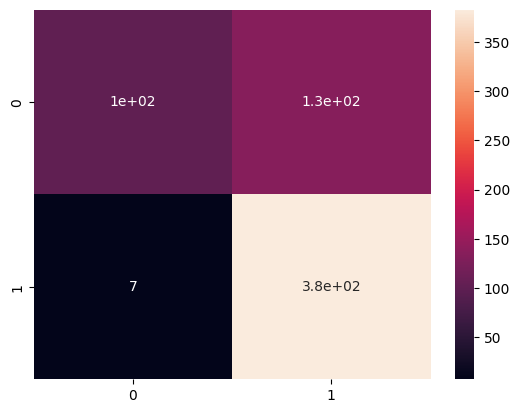

Classification Report:

              precision    recall  f1-score   support

      Normal       0.93      0.43      0.59       234
   Pneumonia       0.74      0.98      0.84       390

    accuracy                           0.77       624
   macro avg       0.84      0.70      0.72       624
weighted avg       0.81      0.77      0.75       624



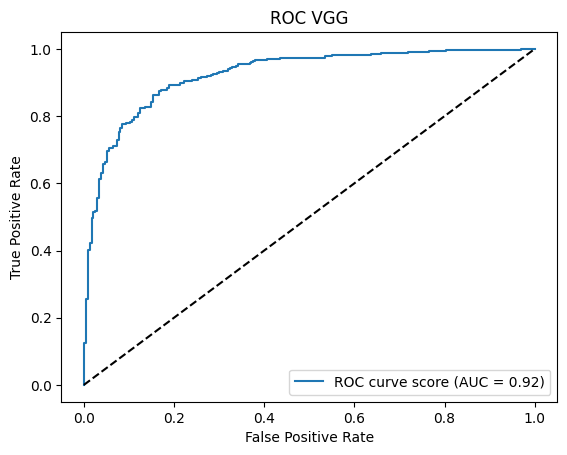

In [42]:

# Get predictions on test data
y_pred_prob = model_vgg.predict(X_test)
y_pred = np.round(y_pred_prob)  # binary classification with sigmoid



# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)
plt.savefig('../figures/confusion_matrix_vgg.png')
print("Confusion Matrix:\n", cm)
plt.show()
mlflow.log_artifact('../figures/confusion_matrix_vgg.png')

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))

# ROC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve score (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC VGG')
plt.savefig('../figures/ROC_vgg.png')
plt.legend(loc='lower right')
plt.show()
mlflow.log_artifact('../figures/ROC_vgg.png')



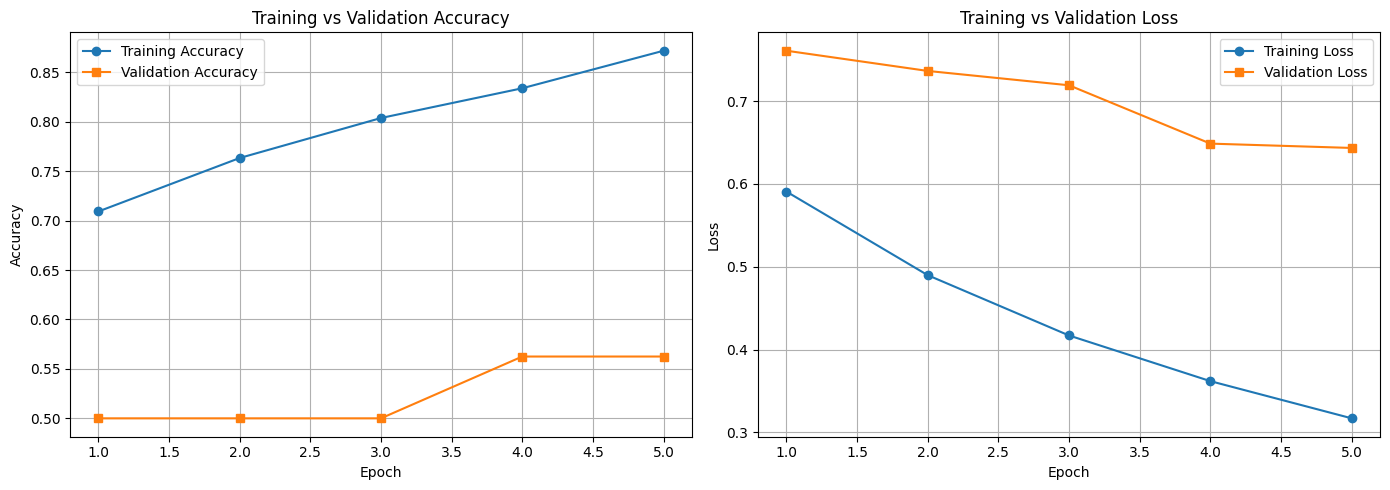

In [ ]:
# Extract metrics
train_acc = history_vgg.history['accuracy']
val_acc = history_vgg.history['val_accuracy']
train_loss = history_vgg.history['loss']
val_loss = history_vgg.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Create subplots
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("../figures/training_val_curves_vgg.png")
mlflow.log_artifact("../figures/training_val_curves_vgg.png")


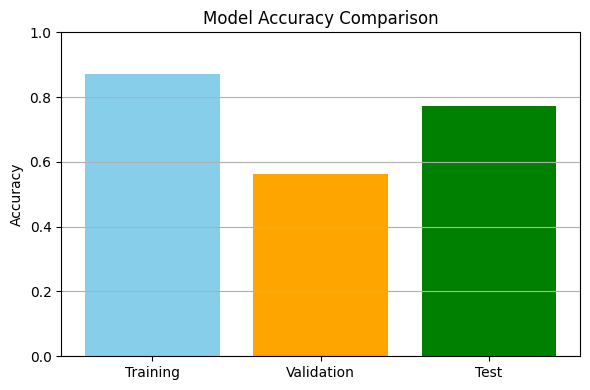

In [54]:
train_acc = history_vgg.history['accuracy'][-1]        # Final training accuracy
val_acc = history_vgg.history['val_accuracy'][-1]      # Final validation accuracy
test_loss, test_acc = model_vgg.evaluate(X_test, y_test, verbose=0)
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/accuracy_comparison_vgg.png")
plt.show()
mlflow.log_artifact("../figures/accuracy_comparison_vgg.png")

## Fitting DenseNet

In [ ]:
# Setting new experiment for the new model
mlflow.end_run()
mlflow.tensorflow.autolog()
mlflow.set_experiment("TransferLearning-CNN-DenseNet")

<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/709472600215187329', creation_time=1748009918562, experiment_id='709472600215187329', last_update_time=1748009918562, lifecycle_stage='active', name='TransferLearning-CNN-DenseNet', tags={}>

In [51]:
with mlflow.start_run(run_name="run-densenet"):
    history_densenet = model_densenet.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=32,
        shuffle=True
    )
     # log the model
    mlflow.keras.log_model(model_densenet,"model")
model_densenet.save('../models/my_model_densenet.keras')

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7311 - loss: 0.5892

163/163 ━━━━━━━━━━━━━━━━━━━━ 561s 3s/step - accuracy: 0.7315 - loss: 0.5883 - val_accuracy: 0.6250 - val_loss: 0.5092
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 507s 3s/step - accuracy: 0.9111 - loss: 0.2313 - val_accuracy: 0.6875 - val_loss: 0.5178
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.9367 - loss: 0.1785

163/163 ━━━━━━━━━━━━━━━━━━━━ 577s 3s/step - accuracy: 0.9367 - loss: 0.1785 - val_accuracy: 0.6875 - val_loss: 0.4823
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 493s 3s/step - accuracy: 0.9396 - loss: 0.1579 - val_accuracy: 0.6875 - val_loss: 0.5187
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 19s/step - accuracy: 0.9450 - loss: 0.1462 

163/163 ━━━━━━━━━━━━━━━━━━━━ 3067s 19s/step - accuracy: 0.9450 - loss: 0.1462 - val_accuracy: 0.6875 - val_loss: 0.4634
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2025/05/23 17:48:34 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/23 17:48:51 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Evaluation & logging artifacts DenseNet

20/20 ━━━━━━━━━━━━━━━━━━━━ 61s 3s/step
Confusion Matrix:
 [[129 105]
 [  6 384]]


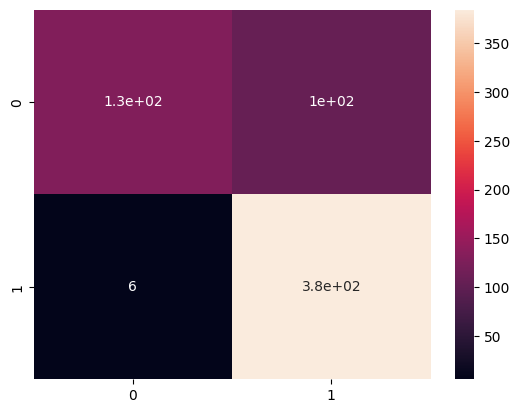

Classification Report:

              precision    recall  f1-score   support

      Normal       0.96      0.55      0.70       234
   Pneumonia       0.79      0.98      0.87       390

    accuracy                           0.82       624
   macro avg       0.87      0.77      0.79       624
weighted avg       0.85      0.82      0.81       624



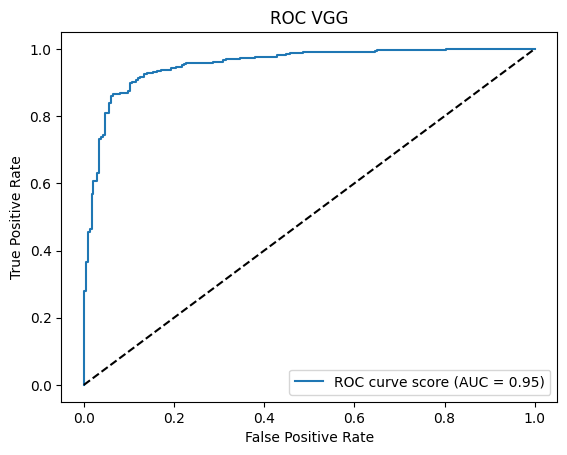

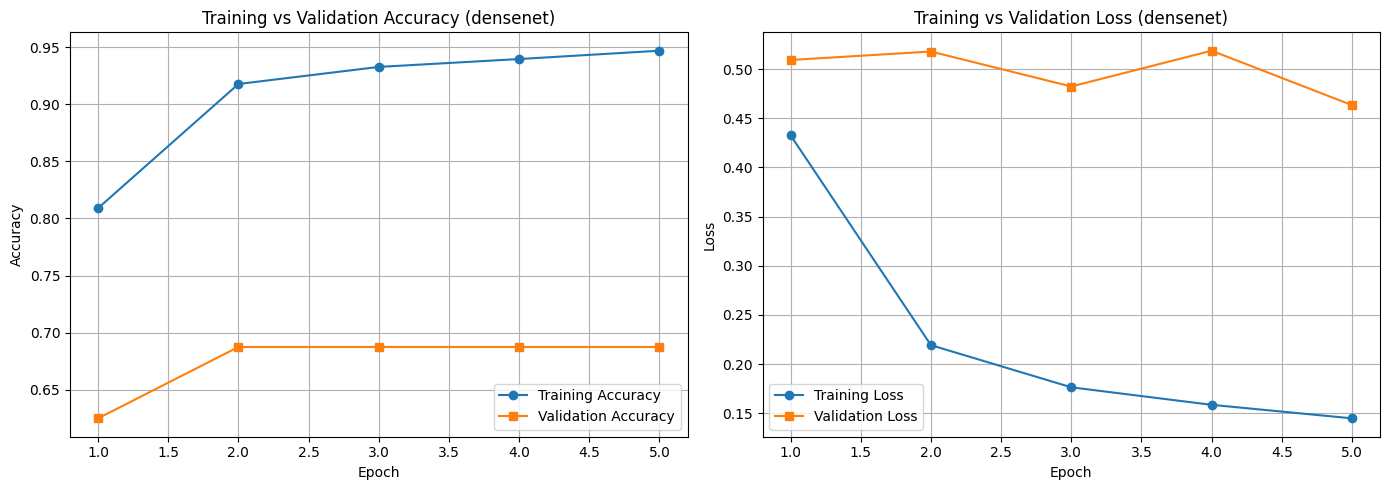

<Figure size 640x480 with 0 Axes>

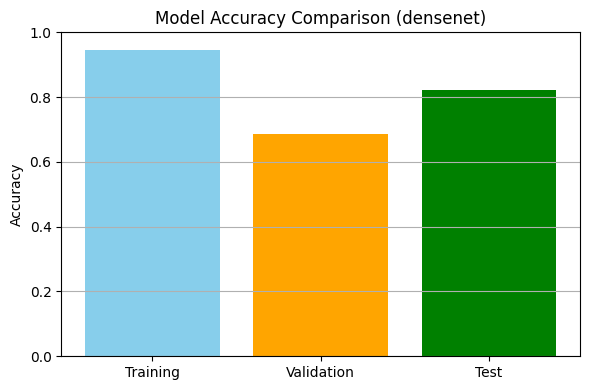

In [ ]:

# Get predictions on test data
y_pred_prob = model_densenet.predict(X_test)
y_pred = np.round(y_pred_prob)  # binary classification with sigmoid



# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)
plt.savefig('../figures/confusion_matrix_densenet.png')
print("Confusion Matrix:\n", cm)
plt.show()
mlflow.log_artifact('../figures/confusion_matrix_densenet.png')

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))

# ROC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve score (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC VGG')
plt.savefig('../figures/ROC_densenet.png')
plt.legend(loc='lower right')
plt.show()
mlflow.log_artifact('../figures/ROC_densenet.png')


# Extract metrics
train_acc = history_densenet.history['accuracy']
val_acc = history_densenet.history['val_accuracy']
train_loss = history_densenet.history['loss']
val_loss = history_densenet.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Create subplots
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy (densenet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss (densenet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("../figures/training_val_curves_densenet.png")
mlflow.log_artifact("../figures/training_val_curves_densenet.png")


# Model accuracy train vs val vs test
train_acc = history_densenet.history['accuracy'][-1]        # Final training accuracy
val_acc = history_densenet.history['val_accuracy'][-1]      # Final validation accuracy
test_loss, test_acc = model_densenet.evaluate(X_test, y_test, verbose=0)
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Model Accuracy Comparison (densenet)')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/accuracy_comparison_densenet.png")
plt.show()
mlflow.log_artifact("../figures/accuracy_comparison_densenet.png")

## Fitting ResNet

In [56]:
# Setting new experiment for the new model
mlflow.end_run()
mlflow.tensorflow.autolog()
mlflow.set_experiment("TransferLearning-CNN-ResNet")

2025/05/23 18:33:26 INFO mlflow.tracking.fluent: Experiment with name 'TransferLearning-CNN-ResNet' does not exist. Creating a new experiment.


<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/539121914514450925', creation_time=1748018006128, experiment_id='539121914514450925', last_update_time=1748018006128, lifecycle_stage='active', name='TransferLearning-CNN-ResNet', tags={}>

In [57]:
with mlflow.start_run(run_name="run-resnet"):
    history_resnet = model_resnet.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=5,
        batch_size=32,
        shuffle=True
    )
     # log the model
    mlflow.keras.log_model(model_resnet,"model")
model_densenet.save('../models/my_model_resnet.keras')

Epoch 1/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7746 - loss: 0.4832

163/163 ━━━━━━━━━━━━━━━━━━━━ 450s 3s/step - accuracy: 0.7752 - loss: 0.4821 - val_accuracy: 0.7500 - val_loss: 0.4314
Epoch 2/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 462s 3s/step - accuracy: 0.9427 - loss: 0.1483 - val_accuracy: 0.6875 - val_loss: 0.5064
Epoch 3/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 452s 3s/step - accuracy: 0.9492 - loss: 0.1315 - val_accuracy: 0.7500 - val_loss: 0.4692
Epoch 4/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.9609 - loss: 0.1107 - val_accuracy: 0.7500 - val_loss: 0.4806
Epoch 5/5
163/163 ━━━━━━━━━━━━━━━━━━━━ 436s 3s/step - accuracy: 0.9620 - loss: 0.1019 - val_accuracy: 0.7500 - val_loss: 0.4826
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


2025/05/23 19:12:29 WARNING mlflow.keras.save: You are saving a Keras model without specifying model signature.
2025/05/23 19:12:44 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


## Evaluation & logging artifacts ResNet

20/20 ━━━━━━━━━━━━━━━━━━━━ 59s 3s/step
Confusion Matrix:
 [[118 116]
 [  4 386]]


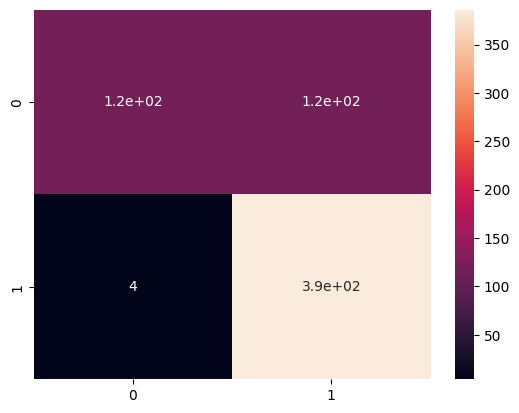

Classification Report:

              precision    recall  f1-score   support

      Normal       0.97      0.50      0.66       234
   Pneumonia       0.77      0.99      0.87       390

    accuracy                           0.81       624
   macro avg       0.87      0.75      0.76       624
weighted avg       0.84      0.81      0.79       624



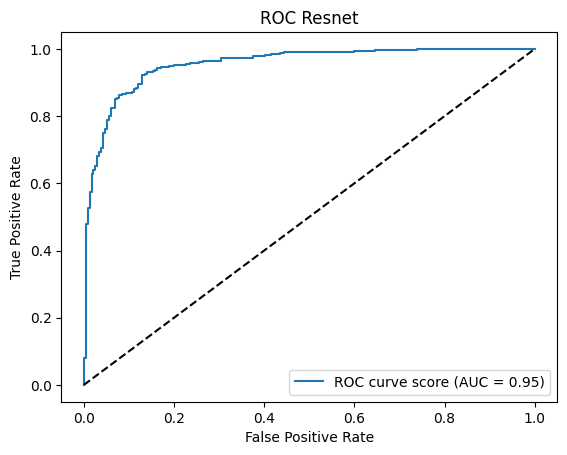

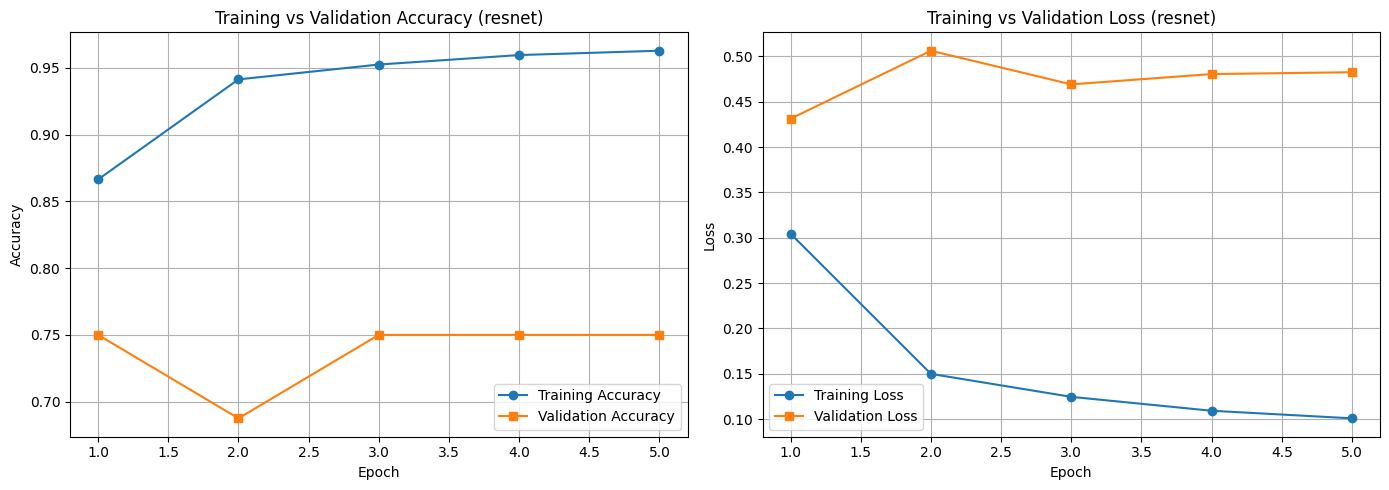

<Figure size 640x480 with 0 Axes>

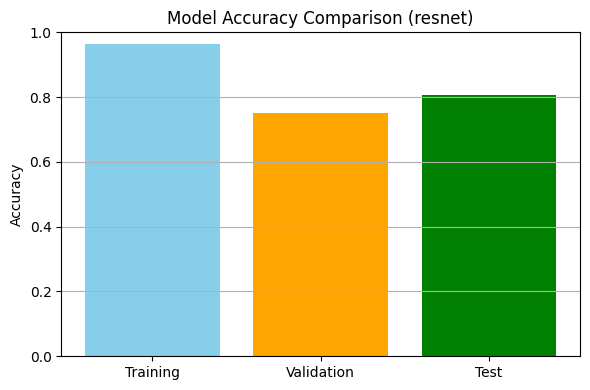

In [58]:

# Get predictions on test data
y_pred_prob = model_resnet.predict(X_test)
y_pred = np.round(y_pred_prob)  # binary classification with sigmoid



# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm,annot=True)
plt.savefig('../figures/confusion_matrix_resnet.png')
print("Confusion Matrix:\n", cm)
plt.show()
mlflow.log_artifact('../figures/confusion_matrix_resnet.png')

# Classification report
print("Classification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Normal', 'Pneumonia']))

# ROC score
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve score (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Random classifier line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Resnet')
plt.savefig('../figures/ROC_resnet.png')
plt.legend(loc='lower right')
plt.show()
mlflow.log_artifact('../figures/ROC_resnet.png')


# Extract metrics
train_acc = history_resnet.history['accuracy']
val_acc = history_resnet.history['val_accuracy']
train_loss = history_resnet.history['loss']
val_loss = history_resnet.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Create subplots
plt.figure(figsize=(14, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, label='Training Accuracy', marker='o')
plt.plot(epochs, val_acc, label='Validation Accuracy', marker='s')
plt.title('Training vs Validation Accuracy (resnet)')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='s')
plt.title('Training vs Validation Loss (resnet)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
plt.savefig("../figures/training_val_curves_resnet.png")
mlflow.log_artifact("../figures/training_val_curves_resnet.png")


# Model accuracy train vs val vs test
train_acc = history_resnet.history['accuracy'][-1]        # Final training accuracy
val_acc = history_resnet.history['val_accuracy'][-1]      # Final validation accuracy
test_loss, test_acc = model_resnet.evaluate(X_test, y_test, verbose=0)
accuracies = [train_acc, val_acc, test_acc]
labels = ['Training', 'Validation', 'Test']

plt.figure(figsize=(6, 4))
plt.bar(labels, accuracies, color=['skyblue', 'orange', 'green'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Model Accuracy Comparison (resnet)')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/accuracy_comparison_resnet.png")
plt.show()
mlflow.log_artifact("../figures/accuracy_comparison_resnet.png")

In [59]:
# List all experiments
experiments = mlflow.search_experiments()

In [60]:
experiments

[<Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/539121914514450925', creation_time=1748018006128, experiment_id='539121914514450925', last_update_time=1748018006128, lifecycle_stage='active', name='TransferLearning-CNN-ResNet', tags={}>,
 <Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/709472600215187329', creation_time=1748009918562, experiment_id='709472600215187329', last_update_time=1748009918562, lifecycle_stage='active', name='TransferLearning-CNN-DenseNet', tags={}>,
 <Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/276209147749053906', creation_time=1747995881465, experiment_id='276209147749053906', last_update_time=1747995881465, lifecycle_stage='active', name='TransferLearning-CNN-VGG', tags={}>,
 <Experiment: artifact_location='file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns/0', cre

In [61]:
print(mlflow.get_tracking_uri())

file:///c:/Users/User/Desktop/DL_transfer_CNN_pneumonia/notebooks/mlruns


In [62]:
for exp in experiments:
    print(f"Experiment ID: {exp.experiment_id}, Experiment Name: {exp.name}")

Experiment ID: 539121914514450925, Experiment Name: TransferLearning-CNN-ResNet
Experiment ID: 709472600215187329, Experiment Name: TransferLearning-CNN-DenseNet
Experiment ID: 276209147749053906, Experiment Name: TransferLearning-CNN-VGG
Experiment ID: 0, Experiment Name: Default


# 6. Comparaison des modèles 

In [ ]:
models = [model_vgg,model_densenet,model_resnet]
test_accuracies =[]
for model in models:
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
    test_accuracies.append(test_acc)
labels = ["VGG", "DenseNet", "ResNet"]
plt.figure(figsize=(6, 4))
plt.bar(labels, test_accuracies, color=['blue', 'orange', 'green'])
plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.grid(axis='y')
plt.tight_layout()
plt.savefig("../figures/model_comparison_resnet.png")
plt.show()
    

---

## Mlflow ui
Pour visualiser les expérimentations suivies 
- changer de répertoire:
cd  notebooks/
- écrire
`mlflow ui `
- ouvrir http://localhost:5000